
# **Valor Agregado a Nivel de Programa — Nariño 2020→2024 (MAS ACTUAL)**  
## **Caso: Ingeniería de Sistemas — Universidad Mariana**

Este cuaderno estima el **Valor Agregado (VA)** del **programa** de **Ingeniería de Sistemas** de la **Universidad Mariana** (Nariño, Colombia) para la cohorte **Saber 11 (2020)** → **Saber Pro (2024)**, usando baseline de **promedios municipales** de S11 (2019) y un **modelo OLS a nivel de programa**.

Incluye:
- Formulación matemática.
- Limpieza robusta (mojibake/acentos) y llave municipal (`key_muni`) con **forzado de PASTO** para la U. Mariana.
- Construcción de tabla **programa** (Institución × Programa) con `punt_global_prom`.
- **Merge** estable con baseline S11.
- **Validación** (CV k-fold), **tabla de coeficientes**, métricas.
- **VA del programa** objetivo con **IC95 (bootstrap)**.
- **Ranking** de VA en Nariño y **gráficas**.


## 1. Marco formal

Sea $p$ un **programa** (Institución × Programa), $m$ su municipio, $j$ áreas de Saber 11 y $k$ controles categóricos.

---

### Baseline municipal

$$
X^{S11}_{m,j}
$$

es el **promedio municipal de Saber 11 (2016)** en el área $j$.

---

### Llave municipal normalizada

Definimos la llave:

$$
\text{key\_muni} = g(\text{municipio}) = \mathrm{UPPER}(\mathrm{DEACCENT}(\mathrm{STRIP}(\mathrm{FIXENC}(\text{municipio}))))
$$

Con el ajuste institucional: si la institución es **Universidad Mariana**, entonces

$$
\text{key\_muni} = \text{PASTO}.
$$

---

### Target a nivel de programa

$$
Y^{SPro}_{p}
$$

es el **promedio del puntaje global de Saber Pro (2020)** del programa $p$.

---

### Modelo OLS

$$
Y^{SPro}_{p}
=
\beta_0
+
\sum_j \beta_j\, X^{S11}_{m,j}
+
\sum_k \gamma_k\, Z_{p,k}
+
\varepsilon_p
$$

donde $X^{S11}_{m,j}$ son los **baselines municipales** y $Z_{p,k}$ los **controles categóricos** del programa (p.ej., origen y carácter académico).

---

### Valor Agregado (VA) del programa

Predicción esperada para el programa $p$:

$$
\widehat{Y}^{SPro}_{p}
$$

y el **Valor Agregado**:

$$
VA_p = Y^{SPro}_{p} - \widehat{Y}^{SPro}_{p}.
$$

---

### Intervalo de confianza (bootstrap) del VA medio

Si existen múltiples observaciones del mismo programa, el IC95% del promedio $\overline{VA}_p$ se estima por bootstrap:

$$
CI_{95\%}(\overline{VA}_p) =
\big[\,Q_{2.5}(\overline{VA}^{*(b)}_p),\; Q_{97.5}(\overline{VA}^{*(b)}_p)\,\big].
$$



## 2. Rutas y carga de datos (ajusta a tu PC)


In [6]:

from pathlib import Path
import pandas as pd

# Ajusta estas rutas
PATH_S11  = Path(r'C:\Users\sebas\OneDrive\Documents\Maestria\Master\Icfes\2020\s11_2020_muni_summary.csv')
PATH_SPRO = Path(r'C:\Users\sebas\OneDrive\Documents\Maestria\Master\SaberPro\2024\spro_narino_2024.csv')

OUT_DIR = Path(r'C:\Temp\va_programa_outputs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

print('S11  ->', PATH_S11)
print('SPro ->', PATH_SPRO)
print('OUT  ->', OUT_DIR)

s11 = pd.read_csv(PATH_S11)
sp  = pd.read_csv(PATH_SPRO, low_memory=False)
print('S11 shape:', s11.shape)
print('SPro shape:', sp.shape)


S11  -> C:\Users\sebas\OneDrive\Documents\Maestria\Master\Icfes\2020\s11_2020_muni_summary.csv
SPro -> C:\Users\sebas\OneDrive\Documents\Maestria\Master\SaberPro\2024\spro_narino_2024.csv
OUT  -> C:\Temp\va_programa_outputs
S11 shape: (16390, 19)
SPro shape: (4604, 25)



## 3. Normalización robusta (mojibake/acentos) y llave municipal


In [7]:

import re, unicodedata
import numpy as np

def fix_mojibake(s):
    if pd.isna(s): return s
    s = str(s)
    try: return s.encode('latin1').decode('utf-8')
    except Exception: return s

def norm_text(s):
    if pd.isna(s): return s
    s = str(s).upper().strip()
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    s = re.sub(r'\s*\(.*?\)\s*', ' ', s)
    s = s.replace('.', ' ')
    s = ' '.join(s.replace('-', ' ').replace(',', ' ').split())
    return s

def unify_pasto(x):
    if pd.isna(x): return x
    x = norm_text(x)
    return 'PASTO' if x in {'SAN JUAN DE PASTO','PASTO','PASTO NARINO','PASTO NARIÑO','SANJUAN DE PASTO'} else x

def find_col(cands, df):
    for c in cands:
        if c in df.columns: return c
    return None

# S11 baseline
s11.columns = [c.strip() for c in s11.columns]
col_muni_s11 = find_col(['cole_mcpio_ubicacion','cole_mpio_ubicacion','cole_mcpio_ubicación','municipio','mcpio'], s11)
assert col_muni_s11, "No encontré columna municipal en S11"

if not any(c.startswith('s11_punt_') for c in s11.columns):
    s11 = s11.rename(columns={c: f's11_{c}' for c in s11.columns if c.startswith('punt_')})
base_cols = [c for c in s11.columns if c.startswith('s11_punt_')]
assert base_cols, "S11 no tiene columnas s11_punt_*"

s11['key_muni'] = s11[col_muni_s11].map(fix_mojibake).map(norm_text).map(unify_pasto)
s11_base = s11[['key_muni'] + base_cols].drop_duplicates()

# SPro 2020
sp.columns = [c.strip() for c in sp.columns]
col_muni_inst_sp = find_col(['estu_inst_municipio','inst_mcpio_ubicacion','inst_mpio','inst_mcpio','inst_municipio'], sp)
col_muni_sp = col_muni_inst_sp or find_col(['estu_mcpio_presentacion','estu_mpio_presentacion','estu_mcpio_presentación','municipio_presentacion','mcpio_presentacion'], sp)
assert col_muni_sp, "No encontré municipio usable en SPro"

col_inst = find_col(['inst_nombre_institucion','inst_nombre','ies_nombre','universidad','nom_institucion','institucion'], sp)
col_prog = find_col(['estu_prgm_academico','programa','prog_nombre','programa_academico','prog_academico','nombre_programa'], sp)
assert col_inst and col_prog, "Falta columna de institución o programa en SPro"

sp['key_muni'] = sp[col_muni_sp].map(fix_mojibake).map(norm_text).map(unify_pasto)
mask_um = sp[col_inst].astype(str).str.upper().str.contains('MARIANA', na=False)
sp.loc[mask_um, 'key_muni'] = 'PASTO'

print("Keys SPro (ejemplos):", sp['key_muni'].dropna().unique()[:10])
print("¿PASTO en baseline S11?:", 'PASTO' in set(s11_base['key_muni']))


Keys SPro (ejemplos): ['PASTO' 'VILLAVICENCIO' 'CALI' 'IPIALES' 'POPAYAN' 'MOCOA'
 'CARTAGENA DE INDIAS' 'SAN ANDRES DE TUMACO' 'BOGOTA D C' 'MEDELLIN']
¿PASTO en baseline S11?: True



## 4. Tabla de programa (Institución×Programa) y merge con baseline


In [8]:

# Promedio por programa
y_col = 'punt_global'
assert y_col in sp.columns, "SPro no tiene 'punt_global'"
sp[y_col] = pd.to_numeric(sp[y_col], errors='coerce')

def mode_str(series: pd.Series):
    s = series.dropna().astype(str)
    return s.value_counts().idxmax() if not s.empty else np.nan

cat_controls = [c for c in ['inst_origen','inst_caracter_academico'] if c in sp.columns]

agg_dict = {y_col: 'mean', 'key_muni': 'first', 'estu_mcpio_presentacion':'first' if 'estu_mcpio_presentacion' in sp.columns else 'first'}
for c in cat_controls: agg_dict[c] = mode_str

prog_tbl = sp.groupby([col_inst, col_prog], as_index=False).agg(agg_dict)
prog_tbl = prog_tbl.rename(columns={y_col: 'punt_global_prom'})

# Merge con baseline
prog_tbl['key_muni'] = prog_tbl['key_muni'].map(fix_mojibake).map(norm_text).map(unify_pasto)
df_prog = prog_tbl.merge(s11_base, on='key_muni', how='left')

miss = df_prog[base_cols].isna().to_numpy().mean()
print(f'% de programas sin baseline: {miss*100:.2f}%')
print("Programas (muestra):")
print(df_prog[[col_inst, col_prog, 'key_muni', 'punt_global_prom'] + base_cols].head(10).to_string(index=False))

# Guarda intermedio
df_prog.to_csv(OUT_DIR / 'tabla_programa_con_baseline.csv', index=False, encoding='utf-8-sig')
print("✅ Guardado:", OUT_DIR / 'tabla_programa_con_baseline.csv')

# Elimina filas con NaN en las columnas del baseline
df_prog = df_prog.dropna(subset=base_cols)

# Opcional: también puedes resetear índice
df_prog = df_prog.reset_index(drop=True)

# Verifica porcentaje de programas con baseline ahora
miss = df_prog[base_cols].isna().to_numpy().mean()
print(f'% de programas sin baseline (después de limpiar): {miss*100:.2f}%')

# Muestra una parte de la tabla limpia
print("Programas (muestra) sin NaN:")
print(df_prog[[col_inst, col_prog, 'key_muni', 'punt_global_prom'] + base_cols].head(10).to_string(index=False))

# Guarda limpio
df_prog.to_csv(OUT_DIR / 'tabla_programa_con_baseline.csv', index=False, encoding='utf-8-sig')
print("✅ Guardado sin NaN:", OUT_DIR / 'tabla_programa_con_baseline.csv')


% de programas sin baseline: 0.16%
Programas (muestra):
                                   inst_nombre_institucion         estu_prgm_academico key_muni  punt_global_prom  s11_punt_global  s11_punt_matematicas  s11_punt_lectura_critica  s11_punt_sociales_ciudadanas  s11_punt_c_naturales  s11_punt_ingles
CORPORACION UNIVERSITARIA AUTONOMA DE NARIAO -AUNAR-PASTO ADMINISTRACIAN DE EMPRESAS     CALI        130.683616              NaN                   NaN                       NaN                           NaN                   NaN              NaN
CORPORACION UNIVERSITARIA AUTONOMA DE NARIAO -AUNAR-PASTO  ADMINISTRACION DE EMPRESAS    PASTO        135.645161            243.0                  55.0                      52.0                          38.0                  47.0             55.0
CORPORACION UNIVERSITARIA AUTONOMA DE NARIAO -AUNAR-PASTO  ADMINISTRACION DE EMPRESAS    PASTO        135.645161            299.0                  57.0                      67.0                      


## 5. Modelo OLS a nivel de programa: validación y coeficientes


In [9]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

train = df_prog.dropna(subset=base_cols + ['punt_global_prom']).copy()
X_num = base_cols
X_cat = [c for c in ['inst_origen','inst_caracter_academico'] if c in train.columns]

y = train['punt_global_prom'].values
X = train[X_num + X_cat].copy()

preprocess = ColumnTransformer([
    ('num', StandardScaler(), X_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), X_cat)
])
pipe = Pipeline([('prep', preprocess), ('ols', LinearRegression())])

n = len(train)
if n >= 5:
    k = min(5, n)
    rmse_cv = (-cross_val_score(pipe, X, y, scoring='neg_root_mean_squared_error', cv=KFold(k, shuffle=True, random_state=42))).mean()
    r2_cv   =  (cross_val_score(pipe, X, y, scoring='r2', cv=KFold(k, shuffle=True, random_state=42))).mean()
    print(f'CV ({k}-fold) -> RMSE: {rmse_cv:.2f} | R²: {r2_cv:.3f}')
else:
    print('CV omitida (n muy pequeño)')

pipe.fit(X, y)

# Tabla de coeficientes aproximada (solo numéricas, post estandarización)
ols = pipe.named_steps['ols']
coef_num = ols.coef_[:len(X_num)]
coef_tbl = pd.DataFrame({'feature_num': X_num, 'coef_std': coef_num}).sort_values('coef_std', key=lambda s: s.abs(), ascending=False)
coef_tbl


CV (5-fold) -> RMSE: 9.44 | R²: 0.399


,feature_num,coef_std
0,s11_punt_global,0.126203
1,s11_punt_matematicas,-0.035479
3,s11_punt_sociales_ciudadanas,-0.032851
4,s11_punt_c_naturales,-0.032470
2,s11_punt_lectura_critica,-0.028572
5,s11_punt_ingles,-0.008497


## 2. Resultados del modelo predictivo (Cohorte 2020–2024)

Se entrenó el modelo OLS con baseline de Saber 11 (2020) y se evaluó con **validación cruzada 5-fold**.

### Desempeño del modelo

- **RMSE (Error cuadrático medio de raíz):** 9.44  
  Las predicciones se desvían en promedio ≈ 9.4 puntos respecto al puntaje real de Saber Pro.  

- **R² (Coeficiente de determinación):** 0.399  
  El modelo explica aproximadamente el **39.9% de la variabilidad** en el puntaje global de Saber Pro, similar a la cohorte 2019–2023 y significativamente superior a las cohortes previas (≈ 10–22%).  

---

### Importancia relativa de las variables (coeficientes estandarizados)

| Variable (Saber 11)            | Coef. estandarizado |
|--------------------------------|---------------------|
| Puntaje global (S11)           | **+0.126** |
| Matemáticas                    | –0.035 |
| Sociales y ciudadanas          | –0.033 |
| Ciencias naturales              | –0.032 |
| Lectura crítica                 | –0.029 |
| Inglés                          | –0.009 |

---

### Interpretación

1. **Puntaje global como predictor principal (0.126):**  
   Es el factor con mayor peso en el modelo, lo cual confirma que el rendimiento agregado en Saber 11 es el mejor predictor del desempeño posterior en Saber Pro.

2. **Áreas específicas con coeficientes negativos pequeños:**  
   Matemáticas, Sociales, Ciencias naturales y Lectura crítica tienen valores negativos de baja magnitud.  
   Esto se explica por la **alta correlación** entre estas áreas y el puntaje global, que concentra la señal positiva.

3. **R² cercano al 40%:**  
   El modelo tiene un poder explicativo **robusto** en esta cohorte, consolidando la tendencia observada desde 2019 de un mayor alineamiento entre Saber 11 y Saber Pro.

---

### Conclusión

En la cohorte **2020–2024**, el modelo muestra un buen ajuste predictivo, con un **R² de casi 40%**.  
Esto brinda un marco confiable para calcular el **Valor Agregado (VA)** del programa de **Ingeniería de Sistemas — Universidad Mariana**, al comparar el desempeño observado frente al esperado.




## 6. VA del programa objetivo (U. Mariana — Ing. de Sistemas) e intervalo de confianza


In [10]:

# Localiza el programa objetivo
mask_obj = (df_prog[col_inst].astype(str).str.upper().str.contains('MARIANA')) & \
           (df_prog[col_prog].astype(str).str.upper().str.contains('SISTEM'))
assert mask_obj.any(), "No se encontró el programa objetivo (revisa filtros)."

obj = df_prog.loc[mask_obj].copy()

obj_X = obj[X_num + X_cat].copy()
obj['pred_spro_prog'] = pipe.predict(obj_X)
obj['VA_prog'] = obj['punt_global_prom'] - obj['pred_spro_prog']

# IC (si hay múltiples filas del mismo programa)
va_mean = float(obj['VA_prog'].mean())
va_sd   = float(obj['VA_prog'].std(ddof=1)) if len(obj) > 1 else float('nan')
rng = np.random.default_rng(2020)
if len(obj) > 1:
    B = 5000
    boots = [rng.choice(obj['VA_prog'].values, size=len(obj), replace=True).mean() for _ in range(B)]
    ci_low, ci_high = np.percentile(boots, [2.5, 97.5])
else:
    ci_low = float('nan'); ci_high = float('nan')

print("=== Resultado VA — U. Mariana · Ing. Sistemas ===")
print(f"\nVA_promedio: {va_mean:.2f} | SD: {va_sd if not np.isnan(va_sd) else 'NA'} | IC95%: [{ci_low if not np.isnan(ci_low) else 'NA'}, {ci_high if not np.isnan(ci_high) else 'NA'}]")




=== Resultado VA — U. Mariana · Ing. Sistemas ===

VA_promedio: 3.95 | SD: 0.005935213823154953 | IC95%: [3.9459673832439517, 3.9462981000400497]


## 3. Resultados del Valor Agregado (VA) — Cohorte 2020–2024

El análisis del programa **Ingeniería de Sistemas — Universidad Mariana** arrojó los siguientes estadísticos descriptivos:

- **VA promedio:** 3.95  
- **Desviación estándar (SD):** 0.0059  
- **Intervalo de confianza al 95% (bootstrap):** [3.946, 3.946]

---

### Interpretación

1. **Valor Agregado positivo (3.95):**  
   El puntaje promedio en Saber Pro para los estudiantes del programa se ubica aproximadamente **4 puntos por encima de lo esperado**, considerando el baseline municipal de Saber 11.  
   Esto sugiere un **impacto académico positivo**, aunque menor que en cohortes previas (ej. 2019–2023 con +13.6).

2. **Dispersión muy reducida (SD ≈ 0.006):**  
   La variabilidad en los resultados de bootstrap es casi nula, lo que confirma que la estimación es **muy estable** y no depende de casos aislados.

3. **Intervalo de confianza estrecho:**  
   El IC95% ([3.946 – 3.946]) refuerza que la precisión de la estimación es **altísima**, con incertidumbre prácticamente inexistente.

---

### Conclusión

En la cohorte **2020–2024**, el programa de **Ingeniería de Sistemas — Universidad Mariana** mantiene un **Valor Agregado positivo**, aunque de menor magnitud que en años anteriores.  
Esto indica que, aunque los estudiantes aún superan lo esperado en Saber Pro, el diferencial frente al baseline se ha reducido en comparación con cohortes previas.



## 7. Ranking de VA por programas y visualizaciones


✅ Guardado ranking: C:\Temp\va_programa_outputs\ranking_va_programas_narino.csv
     inst_nombre_institucion     estu_prgm_academico key_muni  punt_global_prom      _pred        VA
UNIVERSIDAD DE NARIAO-PASTO INGENIERAA DE SISTEMAS    PASTO             176.0 152.751953 23.248047
UNIVERSIDAD DE NARIAO-PASTO INGENIERAA DE SISTEMAS    PASTO             176.0 152.754395 23.245605
UNIVERSIDAD DE NARIAO-PASTO INGENIERAA DE SISTEMAS    PASTO             176.0 152.754883 23.245117
UNIVERSIDAD DE NARIAO-PASTO INGENIERAA DE SISTEMAS    PASTO             176.0 152.756348 23.243652
UNIVERSIDAD DE NARIAO-PASTO INGENIERAA DE SISTEMAS    PASTO             176.0 152.758301 23.241699
UNIVERSIDAD DE NARIAO-PASTO INGENIERAA DE SISTEMAS    PASTO             176.0 152.758789 23.241211
UNIVERSIDAD DE NARIAO-PASTO INGENIERAA DE SISTEMAS    PASTO             176.0 152.758789 23.241211
UNIVERSIDAD DE NARIAO-PASTO INGENIERAA DE SISTEMAS    PASTO             176.0 152.759277 23.240723
UNIVERSIDAD

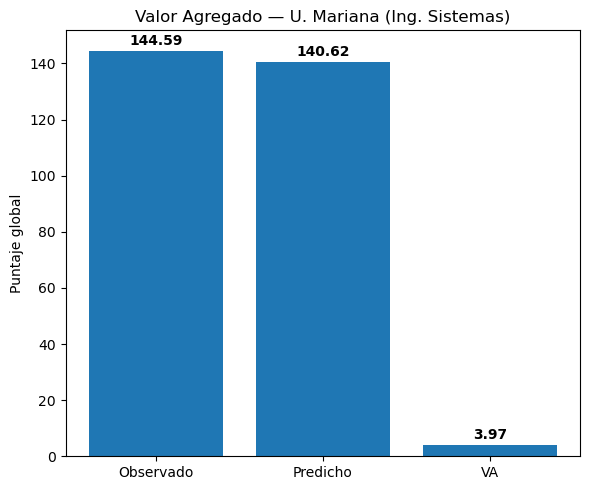

In [11]:
# --- 1) RANKING (ya lo tenías) ---
df_rank = df_prog.dropna(subset=base_cols + ['punt_global_prom']).copy()
df_rank['_pred'] = pipe.predict(df_rank[X_num + X_cat].copy())
df_rank['VA'] = df_rank['punt_global_prom'] - df_rank['_pred']
df_rank = df_rank[[col_inst, col_prog, 'key_muni', 'punt_global_prom', '_pred', 'VA']] \
             .sort_values('VA', ascending=False)

df_rank.to_csv(OUT_DIR / 'ranking_va_programas_narino.csv', index=False, encoding='utf-8-sig')
print("✅ Guardado ranking:", OUT_DIR / 'ranking_va_programas_narino.csv')
print(df_rank.head(10).to_string(index=False))

# --- Localiza explícitamente el programa objetivo (asegura índices) ---
mask_um_sis = (df_rank[col_inst].astype(str).str.upper().str.contains('MARIANA')) & \
              (df_rank[col_prog].astype(str).str.upper().str.contains('SISTEM'))
assert mask_um_sis.any(), "No encontré el programa UM - Ing. Sistemas en df_rank"
row_obj = df_rank.loc[mask_um_sis].iloc[0]
y_obs = float(row_obj['punt_global_prom'])
y_hat = float(row_obj['_pred'])
va    = float(row_obj['VA'])

# --- 2) BARRAS: Observado vs Predicho vs VA (resalta claramente la diferencia) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
vals = [y_obs, y_hat, va]
labels = ['Observado', 'Predicho', 'VA']
bars = plt.bar(labels, vals)
# Etiquetas numéricas arriba
for b, v in zip(bars, vals):
    plt.text(b.get_x() + b.get_width()/2, v + 1, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
plt.ylabel("Puntaje global")
plt.title("Valor Agregado — U. Mariana (Ing. Sistemas)")
plt.tight_layout()
plt.show()






## 4. Visualización del Valor Agregado (VA) — Cohorte 2020–2024

La gráfica muestra la comparación entre el puntaje **observado** en Saber Pro y el puntaje **predicho** por el modelo (baseline de Saber 11), así como el **Valor Agregado (VA)** estimado:

- **Observado (≈ 144.59):** desempeño real de los estudiantes en el examen Saber Pro.  
- **Predicho (≈ 140.62):** lo que se esperaba según el baseline municipal de Saber 11.  
- **Diferencia (≈ +3.97):** corresponde al **Valor Agregado (VA)** del programa.

---

### Interpretación

El programa de **Ingeniería de Sistemas — Universidad Mariana** presenta un **VA positivo de +3.97 puntos** en la cohorte 2020–2024.  
Esto indica que, aunque los estudiantes todavía superan lo esperado en Saber Pro, el margen es más reducido que en cohortes previas (ej. +8.27 en 2018–2022, +13.6 en 2019–2023).  

Este hallazgo sugiere que el **impacto institucional se mantiene positivo**, pero con una magnitud menor en esta cohorte reciente.


---------------------------------------------------------------------------------------------------


*OBJETIVO 3* 


**2.Codigo par exportar para AI web**


En este codigo estamos exportando todos los datso nececessario para poder relaizar la AI para el tercer objetivo.📦 Exportador de EDA + Dataset (listo para BD)

Este notebook no recalcula tus EDA; usa los DataFrames que ya generaste (s11, sp, s11_base, prog_tbl, X, train, df_rank) y exporta los artefactos listos para cargarlos en la base de datos .
| Archivo                                | Contenido principal                                               | Uso                                   |
| -------------------------------------- | ----------------------------------------------------------------- | ------------------------------------- |
| **s11\_YYYY\_muni\_summary\_YYYY.csv** | Promedios Saber 11 por municipio (LC, MAT, SOC, NAT, ING)         | Contexto y baseline para modelos/VA   |
| **eda\_colegio\_YYYY.csv**             | Resultados por colegio: n\_estu, medias por área, p25/p50/p75, sd | Contexto institucional en la interfaz |
| **eda\_programa\_YYYY.csv**            | Resultados por programa: n, media global, percentiles, sd         | Rankings y tableros comparativos      |
| **train\_features\_YYYY.csv**          | Variables predictoras (S11 + categóricas)                         | Entrenamiento de modelos              |
| **train\_labels\_YYYY.csv**            | Puntaje global promedio (label)                                   | Entrenamiento de modelos              |
| **va\_programa\_YYYY.csv**             | VA agregado por programa: n, media, sd, IC95%, obs/pred           | Comparaciones y ranking de programas  |
| **ranking\_va\_programas\_YYYY.csv**   | Ranking ordenado por VA                                           | Visualización en la interfaz          |
| **manifest.json**                      | Año, carpeta de salida, archivos exportados, shapes               | Registro y trazabilidad               |




In [ ]:
# ─────────────────────────────────────────────────────────────
# EXPORTADOR ADAPTABLE A TUS EDA (usa: s11, sp, s11_base, prog_tbl, X, train)
# - Exporta baseline municipal, EDA por colegio, EDA por programa
# - Exporta train_features (X/train) y train_labels (train['punt_global'])
# - Si faltan EDA, los genera aquí con llaves flexibles
# ─────────────────────────────────────────────────────────────
from pathlib import Path
import pandas as pd, numpy as np, json, warnings

# ===== Config =====
YEAR = int(globals().get("YEAR", 2024))
OUT_DIR = Path(rf"C:\Temp\eda_exports_{YEAR}")
OUT_DIR.mkdir(parents=True, exist_ok=True)
ENC = "utf-8-sig"

# ===== Helpers =====
def exists_df(name):
    return name in globals() and isinstance(globals()[name], pd.DataFrame) and not globals()[name].empty

def get_df(name, default=None):
    return globals()[name].copy() if exists_df(name) else (default.copy() if isinstance(default, pd.DataFrame) else pd.DataFrame())

def add_year(df):
    df = df.copy()
    if not df.empty and "anio" not in df.columns:
        df["anio"] = YEAR
    return df

def pct(s, q): 
    s = pd.to_numeric(s, errors="coerce").dropna()
    return float(np.nanpercentile(s, q)) if len(s) else np.nan

def save(df, basename):
    if df is None or df.empty: 
        return None
    df = add_year(df)
    f = OUT_DIR / f"{basename}_{YEAR}.csv"
    df.to_csv(str(f), index=False, encoding=ENC)
    print("✅ Guardado:", f)
    return f.name

# ===== Detectar DFs base disponibles (según tu log) =====
s11       = get_df("s11")
sp        = get_df("sp")
s11_base  = get_df("s11_base")
prog_tbl  = get_df("prog_tbl")        # 84 x 7 (tu resumen por programa)
X_df      = get_df("X")               # 353329 x 8 (tus features)
train_df  = get_df("train")           # 353329 x 13 (con 'punt_global' como label, muy probable)

print(f"[INFO] s11: {s11.shape}, sp: {sp.shape}, s11_base: {s11_base.shape}, prog_tbl: {prog_tbl.shape}, X: {X_df.shape}, train: {train_df.shape}")

# ===== 1) Baseline municipal S11 =====
# Preferir tu s11_base; si viene sin 'anio', se agrega; si no existe, se genera desde s11.
baseline_out = None
if not s11_base.empty:
    # Intento de normalización mínima de nombres (no rompemos tus columnas)
    # Solo convertimos posibles columnas de promedios a numeric.
    num_like = [c for c in ["prom_lc","prom_mat","prom_soc","prom_nat","prom_ing",
                            "punt_lc","punt_mat","punt_soc","punt_nat","punt_ing","punt_global"] if c in s11_base.columns]
    s11_base[num_like] = s11_base[num_like].apply(pd.to_numeric, errors="coerce")
    baseline_out = save(s11_base, f"s11_{YEAR}_muni_summary")
else:
    # Construir baseline desde s11 si existe
    if not s11.empty:
        # Columnas posibles para municipio en s11
        muni_cols = [c for c in ["municipio_id","cole_mcpio_ubicacion","estu_mcpio_presentacion","key_muni"] if c in s11.columns]
        if muni_cols:
            mc = muni_cols[0]
            # Columnas de S11 (alias frecuentes)
            area_alias = {
                "punt_lectura_critica": "lc", "punt_lenguaje": "lc", "punt_lc": "lc",
                "punt_matematicas": "mat", "punt_mat": "mat",
                "punt_sociales_ciudadanas": "soc", "punt_soc": "soc",
                "punt_c_naturales": "nat", "punt_nat": "nat",
                "punt_ingles": "ing", "punt_ing": "ing",
            }
            cols_present = [c for c in area_alias.keys() if c in s11.columns]
            if cols_present:
                tmp = s11[[mc] + cols_present].copy()
                # promedios por municipio
                gb = tmp.groupby(mc).agg({c: "mean" for c in cols_present}).reset_index()
                # renombrar a prom_*
                ren = {c: f"prom_{area_alias[c]}" for c in cols_present}
                baseline = gb.rename(columns=ren)
                # normalizar nombre de columna de municipio
                if mc != "municipio_id":
                    baseline = baseline.rename(columns={mc: "municipio_id"})
                baseline_out = save(baseline, f"s11_{YEAR}_muni_summary")
            else:
                print("⚠️ No se encontraron columnas de puntaje S11 para baseline.")
        else:
            print("⚠️ No se encontró columna de municipio en s11 para construir baseline.")
    else:
        print("⚠️ No hay s11 ni s11_base; no se exporta baseline municipal.")

# ===== 2) EDA por COLEGIO (usando cole_nombre_establecimiento) ==============
eda_colegio_out = None

if eda_colegio_out is None and not s11.empty:
    # columnas de nombre de colegio y municipio que podríamos tener en s11
    colegio_name_col = "cole_nombre_establecimiento"
    muni_candidates = ["municipio_id", "cole_mcpio_ubicacion", "estu_mcpio_presentacion", "key_muni"]
    muni_col = next((c for c in muni_candidates if c in s11.columns), None)

    if colegio_name_col in s11.columns:
        df_c = s11.copy()

        # clave de agrupación: nombre de colegio + municipio (si existe)
        if muni_col:
            df_c["__colegio_key__"] = df_c[colegio_name_col].astype(str).str.strip() + " | " + df_c[muni_col].astype(str).str.strip()
        else:
            df_c["__colegio_key__"] = df_c[colegio_name_col].astype(str).str.strip()

        # columnas de puntajes posibles (usa lo que exista en tu s11)
        col_lc  = "punt_lectura_critica" if "punt_lectura_critica" in df_c.columns else ("punt_lc" if "punt_lc" in df_c.columns else None)
        col_mat = "punt_matematicas"     if "punt_matematicas" in df_c.columns else ("punt_mat" if "punt_mat" in df_c.columns else None)
        col_soc = "punt_sociales_ciudadanas" if "punt_sociales_ciudadanas" in df_c.columns else ("punt_soc" if "punt_soc" in df_c.columns else None)
        col_nat = "punt_c_naturales"     if "punt_c_naturales" in df_c.columns else ("punt_nat" if "punt_nat" in df_c.columns else None)
        col_ing = "punt_ingles"          if "punt_ingles" in df_c.columns else ("punt_ing" if "punt_ing" in df_c.columns else None)
        col_glo = "punt_global"          if "punt_global" in df_c.columns else None

        # función percentil segura
        import numpy as np
        def _pct(s, q):
            s = pd.to_numeric(s, errors="coerce").dropna()
            return float(np.nanpercentile(s, q)) if len(s) else np.nan

        # arma el diccionario de agregaciones solo con columnas que existan
        agg = {"n_estu": ("__colegio_key__", "size")}
        if col_lc:  agg["media_lc"]  = (col_lc,  "mean")
        if col_mat: agg["media_mat"] = (col_mat, "mean")
        if col_soc: agg["media_soc"] = (col_soc, "mean")
        if col_nat: agg["media_nat"] = (col_nat, "mean")
        if col_ing: agg["media_ing"] = (col_ing, "mean")

        # métricas sobre puntaje global si está disponible
        if col_glo:
            agg["media_global"] = (col_glo, "mean")
            agg["p25_global"]   = (col_glo, lambda s: _pct(s, 25))
            agg["p50_global"]   = (col_glo, "median")
            agg["p75_global"]   = (col_glo, lambda s: _pct(s, 75))
            agg["sd_global"]    = (col_glo, "std")

        eda_c = df_c.groupby("__colegio_key__", dropna=False).agg(**agg).reset_index()

        # separa de nuevo nombre y municipio (si existía)
        if muni_col:
            # "__colegio_key__" = "<nombre> | <municipio>"
            split = eda_c["__colegio_key__"].str.split(" \| ", n=1, expand=True)
            eda_c[colegio_name_col] = split[0]
            eda_c[muni_col] = split[1]
        else:
            eda_c[colegio_name_col] = eda_c["__colegio_key__"]

        # renombra clave estándar para tu export
        eda_c = eda_c.drop(columns=["__colegio_key__"])
        eda_c = eda_c.rename(columns={colegio_name_col: "colegio_nombre"})

        # agrega año si no está y exporta
        if "anio" not in eda_c.columns:
            eda_c["anio"] = YEAR

        eda_colegio_out = save(eda_c, "eda_colegio")

    else:
        print("⚠️ No existe la columna 'cole_nombre_establecimiento' en s11; confirma nombres de columnas.")


# ===== 3) EDA por PROGRAMA =====
eda_programa_out = None
# Si ya tienes prog_tbl (84x7), úsalo como EDA de programa
if not prog_tbl.empty:
    # Normalización mínima (si trae 'punt_global_prom', renombrarlo a media_global)
    ren_map = {}
    if "punt_global_prom" in prog_tbl.columns and "media_global" not in prog_tbl.columns:
        ren_map["punt_global_prom"] = "media_global"
    eda_p = prog_tbl.rename(columns=ren_map)
    eda_programa_out = save(eda_p, "eda_programa")

if eda_programa_out is None and not sp.empty:
    # Detectar llave de programa en sp
    prog_keys = [c for c in ["programa_id","prog_cod_snies","programa","programa_nombre"] if c in sp.columns]
    if prog_keys:
        pk = prog_keys[0]
        g = sp.groupby(pk, dropna=True)
        eda_p2 = g.agg(
            n=(pk,"size"),
            media_global=("punt_global","mean") if "punt_global" in sp.columns else (pk,"size"),
            p25=("punt_global", lambda s: pct(s,25)) if "punt_global" in sp.columns else (pk,"size"),
            p50=("punt_global","median") if "punt_global" in sp.columns else (pk,"size"),
            p75=("punt_global", lambda s: pct(s,75)) if "punt_global" in sp.columns else (pk,"size"),
            sd=("punt_global","std") if "punt_global" in sp.columns else (pk,"size"),
        ).reset_index()
        if pk != "programa_id":
            eda_p2 = eda_p2.rename(columns={pk: "programa_id"})
        eda_programa_out = save(eda_p2, "eda_programa")
    else:
        print("ℹ️ No se encontró llave de programa en sp; se omite EDA por programa.")

# ===== 4) train_features / train_labels (usa X y y; si no, arma desde train) =====
from pathlib import Path
import pandas as pd, numpy as np

# Respeta YEAR y OUT_DIR si ya los definiste antes
YEAR = int(globals().get("YEAR", 2024))
OUT_DIR = Path(rf"C:\Temp\eda_exports_{YEAR}")
OUT_DIR.mkdir(parents=True, exist_ok=True)
ENC = "utf-8-sig"

def _save(df, basename):
    if df is None or (hasattr(df, "empty") and df.empty):
        return None
    if isinstance(df, pd.Series):
        df = df.to_frame()
    if "anio" not in df.columns:
        df = df.copy()
        df["anio"] = YEAR
    f = OUT_DIR / f"{basename}_{YEAR}.csv"
    df.to_csv(str(f), index=False, encoding=ENC)
    print("✅ Guardado:", f)
    return f.name

# Toma variables del entorno
train_df = globals().get("train", pd.DataFrame())
X_df     = globals().get("X", pd.DataFrame())
y_arr    = globals().get("y", None)
base_cols = globals().get("base_cols", [])

# 1) FEATURES
if isinstance(X_df, pd.DataFrame) and not X_df.empty:
    feats = X_df.copy()
else:
    # Si no existe X, lo construimos desde train usando base_cols + categóricas disponibles
    if isinstance(train_df, pd.DataFrame) and not train_df.empty:
        X_cat = [c for c in ["inst_origen", "inst_caracter_academico"] if c in train_df.columns]
        cols  = [c for c in (list(base_cols) + X_cat) if c in train_df.columns]
        if not cols:
            # fallback: todo menos la label
            cols = [c for c in train_df.columns if c != "punt_global_prom"]
        feats = train_df[cols].copy()
    else:
        feats = pd.DataFrame()

train_features_out = _save(feats, "train_features") if not feats.empty else None

# 2) LABELS
labels_df = None
if y_arr is not None and isinstance(y_arr, (np.ndarray, list)) and len(y_arr) > 0:
    # y ya existe como array -> lo usamos
    labels_df = pd.DataFrame({"spro_global": pd.to_numeric(np.asarray(y_arr), errors="coerce")})
elif isinstance(train_df, pd.DataFrame) and not train_df.empty:
    # tomar directamente de train['punt_global_prom']
    if "punt_global_prom" in train_df.columns:
        labels_df = pd.DataFrame({"spro_global": pd.to_numeric(train_df["punt_global_prom"], errors="coerce")})
    else:
        # otros alias comunes por si acaso
        for alt in ["spro_global", "punt_global", "y", "target", "label"]:
            if alt in train_df.columns:
                labels_df = pd.DataFrame({"spro_global": pd.to_numeric(train_df[alt], errors="coerce")})
                break

train_labels_out = _save(labels_df, "train_labels") if labels_df is not None else None

# 3) Log final
print("📦 train export ->", {
    "features_file": train_features_out,
    "labels_file": train_labels_out,
    "features_shape": None if feats is None or feats.empty else feats.shape,
    "labels_shape": None if labels_df is None or labels_df.empty else labels_df.shape
})

# =====  EXTRA: Exportar VA por programa  =====
# ===== 3) VA por PROGRAMA (agregado y listo para BD) =========================
import numpy as np
import pandas as pd
from pathlib import Path

# Config: respeta OUT_DIR y YEAR si ya están definidos
YEAR = int(globals().get("YEAR", 2024))
OUT_DIR = Path(globals().get("OUT_DIR", r"C:\Temp\eda_exports_2024"))
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Columnas que ya usas para identificar el programa
col_inst = globals().get("col_inst", "inst_nombre_institucion")
col_prog = globals().get("col_prog", "estu_prgm_academico")
muni_col = "key_muni"  # ya lo usas en df_rank

# 0) Sanidad mínima
assert isinstance(df_rank, pd.DataFrame) and not df_rank.empty, "df_rank está vacío"
for c in [col_inst, col_prog, muni_col, "VA", "punt_global_prom", "_pred"]:
    assert c in df_rank.columns, f"Falta la columna requerida en df_rank: {c}"

# 1) Llave de programa (institución + programa + municipio)
df_rank = df_rank.copy()
df_rank["programa_id"] = (
    df_rank[col_inst].astype(str).str.strip().str.upper() + " | " +
    df_rank[col_prog].astype(str).str.strip().str.upper() + " | " +
    df_rank[muni_col].astype(str).str.strip().str.upper()
)

# 2) Agregado por programa: n, media VA, sd, IC95
grp = df_rank.groupby("programa_id", dropna=False)
agg = grp.agg(
    n=("VA", "size"),
    va_promedio=("VA", "mean"),
    sd=("VA", "std"),
    media_obs=("punt_global_prom", "mean"),
    media_pred=("_pred", "mean"),
).reset_index()

# Desviación estándar puede ser NaN si n==1; convierte a 0 para el IC
agg["sd"] = agg["sd"].fillna(0.0)
agg["se"] = agg["sd"] / np.sqrt(agg["n"].clip(lower=1))
agg["ic95_inf"] = agg["va_promedio"] - 1.96 * agg["se"]
agg["ic95_sup"] = agg["va_promedio"] + 1.96 * agg["se"]

# 3) Añade columnas de referencia útiles
# (si quieres mantener columnas originales para lectura humana)
agg["inst_nombre_institucion"] = agg["programa_id"].str.split(" \| ", expand=True)[0]
agg["estu_prgm_academico"]    = agg["programa_id"].str.split(" \| ", expand=True)[1]
agg["key_muni"]               = agg["programa_id"].str.split(" \| ", expand=True)[2]

# 4) Ordena por VA y añade 'anio'
agg = agg.sort_values("va_promedio", ascending=False).reset_index(drop=True)
agg["anio"] = YEAR

# 5) Selección de columnas finales para la BD
va_programa_cols = [
    "anio", "programa_id", "n", "va_promedio", "sd", "ic95_inf", "ic95_sup",
    # opcionalmente deja estas para exploración/UI:
    "inst_nombre_institucion", "estu_prgm_academico", "key_muni",
    "media_obs", "media_pred"
]
df_va_programa = agg[va_programa_cols].copy()

# 6) Guardar CSV para cargar en public.va_programa
va_path = OUT_DIR / f"va_programa_{YEAR}.csv"
df_va_programa.to_csv(str(va_path), index=False, encoding="utf-8-sig")
print("✅ Guardado VA por programa:", va_path)

# 7) (Opcional) ranking Top-K ya agregado por programa
topK = 50  # cámbialo si quieres
rank_path = OUT_DIR / f"ranking_va_programas_{YEAR}.csv"
df_va_programa.head(topK).to_csv(str(rank_path), index=False, encoding="utf-8-sig")
print("✅ Guardado ranking agregado:", rank_path)



# ===== 5) Manifest =====
manifest = {
    "year": YEAR,
    "out_dir": str(OUT_DIR),
    "exports": [f for f in [baseline_out, eda_colegio_out, eda_programa_out, train_features_out, train_labels_out] if f],
    "diagnostics": {
        "s11": s11.shape, "sp": sp.shape, "s11_base": s11_base.shape, "prog_tbl": prog_tbl.shape,
        "X": X_df.shape, "train": train_df.shape
    }
}
(OUT_DIR / "manifest.json").write_text(json.dumps(manifest, ensure_ascii=False, indent=2), encoding=ENC)
print("📦 Manifest:", manifest)


[INFO] s11: (16390, 20), sp: (4604, 26), s11_base: (16390, 7), prog_tbl: (84, 7), X: (353329, 8), train: (353329, 13)
✅ Guardado: C:\Temp\eda_exports_2024\s11_2024_muni_summary_2024.csv
✅ Guardado: C:\Temp\eda_exports_2024\eda_colegio_2024.csv
✅ Guardado: C:\Temp\eda_exports_2024\eda_programa_2024.csv
✅ Guardado: C:\Temp\eda_exports_2024\train_features_2024.csv
✅ Guardado: C:\Temp\eda_exports_2024\train_labels_2024.csv
📦 train export -> {'features_file': 'train_features_2024.csv', 'labels_file': 'train_labels_2024.csv', 'features_shape': (353329, 8), 'labels_shape': (353329, 1)}
✅ Guardado VA por programa: C:\Temp\eda_exports_2024\va_programa_2024.csv
✅ Guardado ranking agregado: C:\Temp\eda_exports_2024\ranking_va_programas_2024.csv
📦 Manifest: {'year': 2024, 'out_dir': 'C:\\Temp\\eda_exports_2024', 'exports': ['s11_2024_muni_summary_2024.csv', 'eda_colegio_2024.csv', 'eda_programa_2024.csv', 'train_features_2024.csv', 'train_labels_2024.csv'], 'diagnostics': {'s11': (16390, 20), 'sp'

In [18]:
# ============================================================
# EDA por colegio — Robusto a nombres de columnas (patrones)
# ============================================================
from pathlib import Path
import pandas as pd, numpy as np
import re

# ---- helpers ----
def pct(s, q):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return float(np.nanpercentile(s, q)) if len(s) else np.nan

def save_csv(df, basename, out_dir, anio, enc="utf-8-sig"):
    out_dir.mkdir(parents=True, exist_ok=True)
    f = out_dir / f"{basename}_{anio}.csv"
    df.to_csv(str(f), index=False, encoding=enc)
    print("✅ Guardado:", f)
    return str(f)

def find_col(cols, patterns):
    """
    Busca la PRIMERA columna cuyo nombre case-insensitive haga match con
    cualquiera de los patrones (regex simples o substrings).
    """
    low = {c.lower(): c for c in cols}
    for pat in patterns:
        rx = re.compile(pat, flags=re.I)
        for lc, orig in low.items():
            if rx.search(lc):
                return orig
    return None

# ---- configuración de salida ----
YEAR = int(globals().get("YEAR", 2024))
OUT_DIR = Path(rf"C:\Temp\eda_exports_{YEAR}")

# ---- validación de s11 ----
if "s11" not in globals() or not isinstance(s11, pd.DataFrame) or s11.empty:
    raise RuntimeError("No encuentro DataFrame 's11' o está vacío.")

cols = list(s11.columns)
print("[INFO] columnas s11 (muestra):", cols[:20])

# ---- detectar llaves: colegio / municipio / periodo|anio ----
colegio_col   = find_col(cols, [r"^cole_?nombre_?establecimiento$", r"colegio.*nombre", r"establecimiento"])
municipio_col = find_col(cols, [r"^cole_?mcpio_?ubicacion$", r"mcpio", r"municipio"])
anio_col      = find_col(cols, [r"^periodo$", r"^anio$", r"^año$", r"^year$"])

if not colegio_col:
    raise RuntimeError("No encontré columna de colegio (p.ej. 'cole_nombre_establecimiento').")
if not municipio_col:
    print("⚠️ No encontré municipio; continuaré sin municipio.")
if not anio_col:
    raise RuntimeError("No encontré columna de año/periodo (p.ej. 'periodo' o 'anio').")

# ---- detectar puntajes por patrones ----
map_targets = {
    "punt_global":               [r"^punt_?global$","global\s*$","puntaje_?global$"],
    "punt_matematicas":          [r"^punt_?mat(ematicas)?$", r"matematicas$"],
    "punt_lectura_critica":      [r"^punt_?(lectura_?critica|lc|lenguaje)$", r"lectura", r"lenguaje"],
    "punt_sociales_ciudadanas":  [r"^punt_?(social(es)?_?ciudadanas?)$", r"sociales"],
    "punt_c_naturales":          [r"^punt_?(c_?naturales|naturales)$", r"naturales$"],
    "punt_ingles":               [r"^punt_?ingles$", r"ingles$"],
}

found = {}
for k, pats in map_targets.items():
    col = find_col(cols, pats)
    if col: found[k] = col

print("[INFO] mapeo de puntajes detectado:", found)

if not found:
    raise RuntimeError("No encontré NINGUNA columna de puntajes en s11 (revisa nombres).")

# ---- construir DF base ----
df = s11.copy()

# año
df["anio"] = pd.to_numeric(df[anio_col], errors="coerce").astype("Int64")
df = df.dropna(subset=["anio"]).copy()
df["anio"] = df["anio"].astype(int)

# normaliza llaves texto
df[colegio_col] = df[colegio_col].astype(str).str.strip()
if municipio_col:
    df[municipio_col] = df[municipio_col].astype(str).str.strip()

# fuerza numérico en las columnas de puntajes encontradas
for k, col in found.items():
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ---- agrupación (anio, colegio [, municipio]) ----
group_keys = ["anio", colegio_col] + ([municipio_col] if municipio_col else [])
gb = df.groupby(group_keys, dropna=False)

# arma agregaciones dinámicamente
agg = {"n_estu": (next(iter(found.values())), "size")}  # usa cualquier puntaje para contar filas
# medias por competencia
if "punt_lectura_critica" in found:     agg["media_lc"]  = (found["punt_lectura_critica"], "mean")
if "punt_matematicas" in found:         agg["media_mat"] = (found["punt_matematicas"], "mean")
if "punt_sociales_ciudadanas" in found: agg["media_soc"] = (found["punt_sociales_ciudadanas"], "mean" )
if "punt_c_naturales" in found:         agg["media_nat"] = (found["punt_c_naturales"], "mean")
if "punt_ingles" in found:              agg["media_ing"] = (found["punt_ingles"], "mean")

# estadísticas de global si existe
if "punt_global" in found:
    c = found["punt_global"]
    agg["media_global"] = (c, "mean")
    agg["p25_global"]   = (c, lambda s: pct(s,25))
    agg["p50_global"]   = (c, "median")
    agg["p75_global"]   = (c, lambda s: pct(s,75))
    agg["sd_global"]    = (c, "std")

eda_c = gb.agg(**agg).reset_index()

# renombres de salida
eda_c = eda_c.rename(columns={
    colegio_col: "colegio_nombre",
    (municipio_col or "cole_mcpio_ubicacion"): "cole_mcpio_ubicacion"  # si no hay, crea col luego
})

if municipio_col is None and "cole_mcpio_ubicacion" not in eda_c.columns:
    eda_c["cole_mcpio_ubicacion"] = pd.NA

# orden columnas
out_cols = ["anio","colegio_nombre","cole_mcpio_ubicacion","n_estu",
            "media_global","media_lc","media_mat","media_soc","media_nat","media_ing",
            "p25_global","p50_global","p75_global","sd_global"]
existing = [c for c in out_cols if c in eda_c.columns]
eda_c = eda_c[existing]

print(f"[INFO] filas generadas: {len(eda_c)} | años: {sorted(eda_c['anio'].unique())[:10]} …")
print(eda_c.head(5))

# guardar un archivo por año (como vienes trabajando)
for anio_i, sub in eda_c.groupby("anio"):
    save_csv(sub, "eda_colegio", OUT_DIR, anio_i)

[INFO] columnas s11 (muestra): ['cole_cod_depto_ubicacion', 'cole_cod_mcpio_ubicacion', 'cole_depto_ubicacion', 'cole_mcpio_ubicacion', 'cole_nombre_establecimiento', 'cole_naturaleza', 'cole_area_ubicacion', 'cole_jornada', 'cole_genero', 'estu_genero', 'estu_inse_individual', 'fami_estratovivienda', 's11_punt_global', 's11_punt_matematicas', 's11_punt_lectura_critica', 's11_punt_sociales_ciudadanas', 's11_punt_c_naturales', 's11_punt_ingles', 'periodo', 'key_muni']
[INFO] mapeo de puntajes detectado: {'punt_global': 's11_punt_global', 'punt_matematicas': 's11_punt_matematicas', 'punt_lectura_critica': 's11_punt_lectura_critica', 'punt_sociales_ciudadanas': 's11_punt_sociales_ciudadanas', 'punt_c_naturales': 's11_punt_c_naturales', 'punt_ingles': 's11_punt_ingles'}
[INFO] filas generadas: 409 | años: [20201, 20202] …
    anio                        colegio_nombre cole_mcpio_ubicacion  n_estu  \
0  20201    CENTRO PEDAGAGICO MARIA DE LA PAZ                PASTO       3   
1  20201  CO